**Data sampling steps:**
1. Loaded 1st of june data from NSRDB data source
2. Resample the the data set from 30 minute to 5 minute and created a filtered dataset considering DateTime, Temperature and GHI.
3. Append the bus respective information considering ambient and radiant temperature to 25 degree celcius, metabolic rate 1.2 and clothing factor 0.5(summer clothing)

Final output: df_pmv data frame.

In [ ]:
import pandas as pd
import numpy as np

# Load the data
file_path = '/content/June01.xlsx'
df = pd.read_excel(file_path)
df['DateTime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
df = df.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'])
df.set_index('DateTime', inplace=True)

# Custom resampling function
def custom_resample(df, start, end):
    group = df.loc[start:end]
    new_row = group.iloc[-1].copy() if not group.empty else pd.Series(index=df.columns, dtype='float64')
    for column in group.columns:
        last_30_minutes = group[column].dropna()
        if len(last_30_minutes) < 2:
            new_row[column] = last_30_minutes.iloc[-1] if not last_30_minutes.empty else np.nan
        else:
            x = np.arange(len(last_30_minutes))
            y = last_30_minutes.values
            slope, intercept = np.polyfit(x, y, 1)
            predicted_value = slope * (len(last_30_minutes) + 1) + intercept
            new_row[column] = predicted_value
    return new_row

# Resample the data to 5-minute intervals
index = pd.date_range(df.index.min(), df.index.max(), freq='5T')
df_resampled = pd.DataFrame(index=index, columns=df.columns)

for i in range(len(df_resampled)):
    start = df_resampled.index[i] - pd.Timedelta(minutes=30)
    end = df_resampled.index[i]
    df_resampled.iloc[i] = custom_resample(df, start, end)

# Convert numeric columns to float
df_resampled = df_resampled.apply(pd.to_numeric, errors='coerce')

# Handle NaN values using linear interpolation
df_resampled.interpolate(method='linear', inplace=True)

# Reset index to include the DateTime column
df_resampled.reset_index(inplace=True)
df_resampled.rename(columns={'index': 'DateTime'}, inplace=True)

# Select relevant columns
selected_columns = ['DateTime','Temperature', 'GHI']
df_selected = df_resampled[selected_columns].copy()

# Filter data between 07:00 and 23:00
start_time = pd.Timestamp('07:00:00').time()
end_time = pd.Timestamp('23:00:00').time()
df_selected['DateTime'] = pd.to_datetime(df_selected['DateTime'])
df_pmv = df_selected[(df_selected['DateTime'].dt.time >= start_time) &
                     (df_selected['DateTime'].dt.time <= end_time)].copy()

# Add additional columns for PMV calculation
df_pmv['v'] = np.nan
df_pmv['rh'] = np.nan
df_pmv['ta'] = 25
df_pmv['tr'] = 25
df_pmv['met'] = 1.2
df_pmv['clo'] = 0.5
df_pmv.reset_index(drop=True, inplace=True)
df_pmv


,DateTime,Temperature,GHI,v,rh,ta,tr,met,clo
0,2019-06-01 07:00:00,17.4,138.0,NaN,NaN,25,25,1.2,0.5
1,2019-06-01 07:05:00,17.8,167.5,NaN,NaN,25,25,1.2,0.5
2,2019-06-01 07:10:00,18.2,197.0,NaN,NaN,25,25,1.2,0.5
3,2019-06-01 07:15:00,18.6,226.5,NaN,NaN,25,25,1.2,0.5
4,2019-06-01 07:20:00,19.0,256.0,NaN,NaN,25,25,1.2,0.5
...,...,...,...,...,...,...,...,...,...
188,2019-06-01 22:40:00,19.8,0.0,NaN,NaN,25,25,1.2,0.5
189,2019-06-01 22:45:00,19.8,0.0,NaN,NaN,25,25,1.2,0.5
190,2019-06-01 22:50:00,19.8,0.0,NaN,NaN,25,25,1.2,0.5
191,2019-06-01 22:55:00,19.8,0.0,NaN,NaN,25,25,1.2,0.5


**Air velocity and Relative Humidity information update.**

df_pmv data frame Air velocity and Relative Humidity 'v' column and 'rh' column updated considering the Air velocity ranging from 1 to 2.5 m/s and relative humidity randing from 40 to 60.

Final output: Finalized df_pmv dataframe.

In [ ]:
df_pmv['v'] = df_pmv['v'].fillna(pd.Series(np.random.uniform(0, 3, df_pmv.shape[0])))
df_pmv['rh'] = df_pmv['rh'].fillna(pd.Series(np.random.uniform(30, 70, df_pmv.shape[0])))
df_pmv['v'] = 1 + (df_pmv['v'] - df_pmv['v'].min()) * (2.5 - 1) / (df_pmv['v'].max() - df_pmv['v'].min())
df_pmv['rh'] = 40 + (df_pmv['rh'] - df_pmv['rh'].min()) * (60 - 40) / (df_pmv['rh'].max() - df_pmv['rh'].min())
df_pmv['v'] = df_pmv['v'].round(2)
df_pmv['rh'] = df_pmv['rh'].round(2)
print(df_pmv)


               DateTime  Temperature    GHI     v     rh  ta  tr  met  clo
0   2019-06-01 07:00:00         17.4  138.0  1.92  51.96  25  25  1.2  0.5
1   2019-06-01 07:05:00         17.8  167.5  1.55  46.18  25  25  1.2  0.5
2   2019-06-01 07:10:00         18.2  197.0  1.82  56.98  25  25  1.2  0.5
3   2019-06-01 07:15:00         18.6  226.5  2.43  56.15  25  25  1.2  0.5
4   2019-06-01 07:20:00         19.0  256.0  1.59  40.89  25  25  1.2  0.5
..                  ...          ...    ...   ...    ...  ..  ..  ...  ...
188 2019-06-01 22:40:00         19.8    0.0  2.23  55.63  25  25  1.2  0.5
189 2019-06-01 22:45:00         19.8    0.0  1.69  42.22  25  25  1.2  0.5
190 2019-06-01 22:50:00         19.8    0.0  1.54  58.97  25  25  1.2  0.5
191 2019-06-01 22:55:00         19.8    0.0  1.63  43.38  25  25  1.2  0.5
192 2019-06-01 23:00:00         19.8    0.0  2.43  49.24  25  25  1.2  0.5

[193 rows x 9 columns]


**Installation of pythermalcomfort**

The PMV is caluted using the python libarary pythermalcomfort.

In [ ]:
pip install pythermalcomfort

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 2.3 MB/s eta 0:00:00


**Calculation of PMV and PMVcorrected (solar impacted)**

Using the pythermal comfort library calculted the PMV and solar impacted PMVcorrected from the data in df_pmv dataframe.

In [ ]:
from pythermalcomfort.models import pmv_ppd
from pythermalcomfort.utilities import v_relative, clo_dynamic
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import os


ta = df_pmv["ta"].values
tr = df_pmv["tr"].values
vel = df_pmv["v"].values
rh = df_pmv["rh"].values
met = df_pmv["met"].values
clo = df_pmv["clo"].values

v_rel = v_relative(vel, met)
clo_d = clo_dynamic(clo, met)
results = pmv_ppd(ta, tr, v_rel, rh, met, clo_d, 0, "iso", "SI", limit_inputs=False)

df_pmv["vr"] = v_rel
df_pmv["clo_d"] = clo_d
df_pmv["PMV"] = results["pmv"]
df_pmv["PPD"] = results["ppd"]

df_pmv['GHI'] = df_pmv['GHI'].values  # replace 'GHI' with the correct column name if different

# Calculate the new PMV
df_pmv['PMVcorrected'] = df_pmv['PMV'] + 1/200 * df_pmv['GHI']

df_pmv.head(100)

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

,DateTime,Temperature,GHI,v,rh,ta,tr,met,clo,vr,clo_d,PMV,PPD,PMVcorrected
0,2019-06-01 07:00:00,17.4,138.000000,1.92,51.96,25,25,1.2,0.5,1.98,0.5,-1.30,40.2,-0.610000
1,2019-06-01 07:05:00,17.8,167.500000,1.55,46.18,25,25,1.2,0.5,1.61,0.5,-1.23,36.6,-0.392500
2,2019-06-01 07:10:00,18.2,197.000000,1.82,56.98,25,25,1.2,0.5,1.88,0.5,-1.23,36.9,-0.245000
3,2019-06-01 07:15:00,18.6,226.500000,2.43,56.15,25,25,1.2,0.5,2.49,0.5,-1.39,45.1,-0.257500
4,2019-06-01 07:20:00,19.0,256.000000,1.59,40.89,25,25,1.2,0.5,1.65,0.5,-1.28,39.1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2019-06-01 14:55:00,26.8,818.000000,2.44,48.41,25,25,1.2,0.5,2.50,0.5,-1.45,48.1,2.640000
96,2019-06-01 15:00:00,26.8,818.000000,1.85,48.51,25,25,1.2,0.5,1.91,0.5,-1.30,40.4,2.790000
97,2019-06-01 15:05:00,26.7,797.333333,1.08,44.87,25,25,1.2,0.5,1.14,0.5,-1.05,28.3,2.936667
98,2019-06-01 15:10:00,26.6,776.666667,1.71,57.61,25,25,1.2,0.5,1.77,0.5,-1.20,35.1,2.683333


**Bus outside temparature vs inside temperature visualization.** and
**Bus PMV vs PMVcorrected(solar impacted pmv) visualization.**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

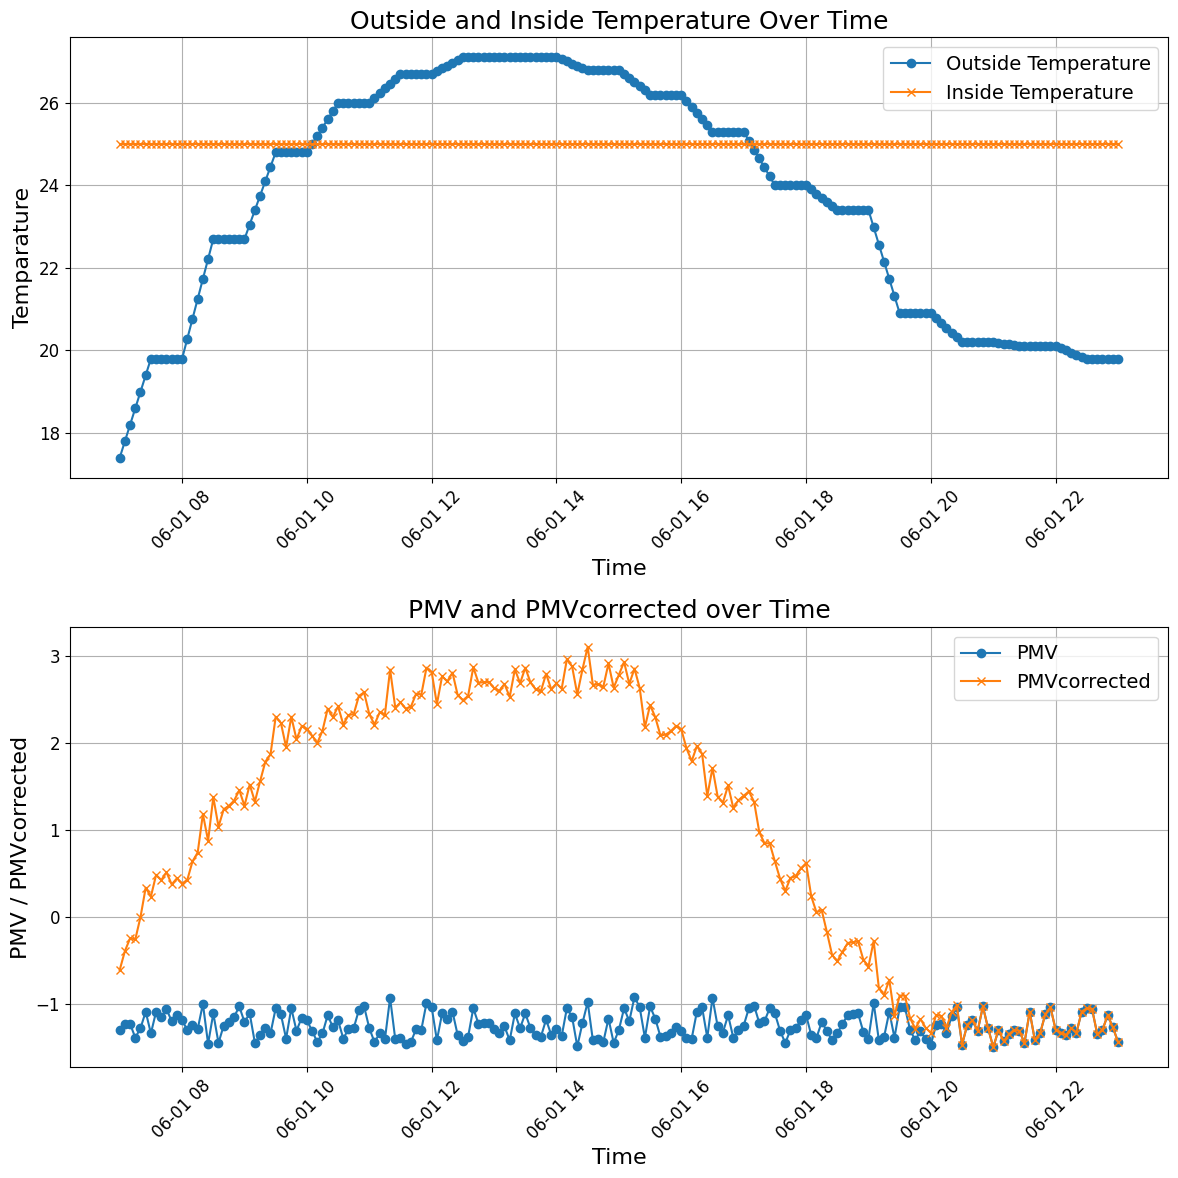

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'DateTime' column to datetime if it's not already
df_pmv['Time'] = pd.to_datetime(df_pmv['DateTime'])

# Set 'Time' as the index
df_pmv.set_index('Time', inplace=True)

# Set font sizes
plt.rcParams.update({'font.size': 14})  # Update the global font size to 14

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# Plot 'Temperature' and 'ta' columns
ax[0].plot(df_pmv.index, df_pmv['Temperature'], label='Outside Temperature', marker='o')
ax[0].plot(df_pmv.index, df_pmv['ta'], label='Inside Temperature', marker='x')
ax[0].set_xlabel('Time', fontsize=16)
ax[0].set_ylabel('Temparature', fontsize=16)
ax[0].set_title('Outside and Inside Temperature Over Time', fontsize=18)
ax[0].legend(fontsize=14)
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45, labelsize=12)
ax[0].tick_params(axis='y', labelsize=12)
#ax[0].set_xticklabels([])  # Remove x-axis tick labels

# Plot 'PMV' and 'PMVcorrected' columns
ax[1].plot(df_pmv.index, df_pmv['PMV'], label='PMV', marker='o')
ax[1].plot(df_pmv.index, df_pmv['PMVcorrected'], label='PMVcorrected', marker='x')
ax[1].set_xlabel('Time', fontsize=16)
ax[1].set_ylabel('PMV / PMVcorrected', fontsize=16)
ax[1].set_title('PMV and PMVcorrected over Time', fontsize=18)
ax[1].legend(fontsize=14)
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45, labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)
#ax[1].set_xticklabels([])  # Remove x-axis tick labels

# Adjust layout
plt.tight_layout()
plt.show()


**Solar incidence angle determination of both side of the bus** and
**Solar irradiance determination of both side of the bus**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                  Time            DateTime  Temperature         GHI     v  \
0  2019-06-01 07:00:00 2019-06-01 07:00:00         17.4  138.000000  1.92   
1  2019-06-01 07:05:00 2019-06-01 07:05:00         17.8  167.500000  1.55   
2  2019-06-01 07:10:00 2019-06-01 07:10:00         18.2  197.000000  1.82   
3  2019-06-01 07:15:00 2019-06-01 07:15:00         18.6  226.500000  2.43   
4  2019-06-01 07:20:00 2019-06-01 07:20:00         19.0  256.000000  1.59   
..                 ...                 ...          ...         ...   ...   
95 2019-06-01 14:55:00 2019-06-01 14:55:00         26.8  818.000000  2.44   
96 2019-06-01 15:00:00 2019-06-01 15:00:00         26.8  818.000000  1.85   
97 2019-06-01 15:05:00 2019-06-01 15:05:00         26.7  797.333333  1.08   
98 2019-06-01 15:10:00 2019-06-01 15:10:00         26.6  776.666667  1.71   
99 2019-06-01 15:15:00 2019-06-01 15:15:00         26.5  756.000000  1.02   

       rh  ta  tr  met  clo    vr  clo_d   PMV   PPD  PMVcorrected  Left_Si

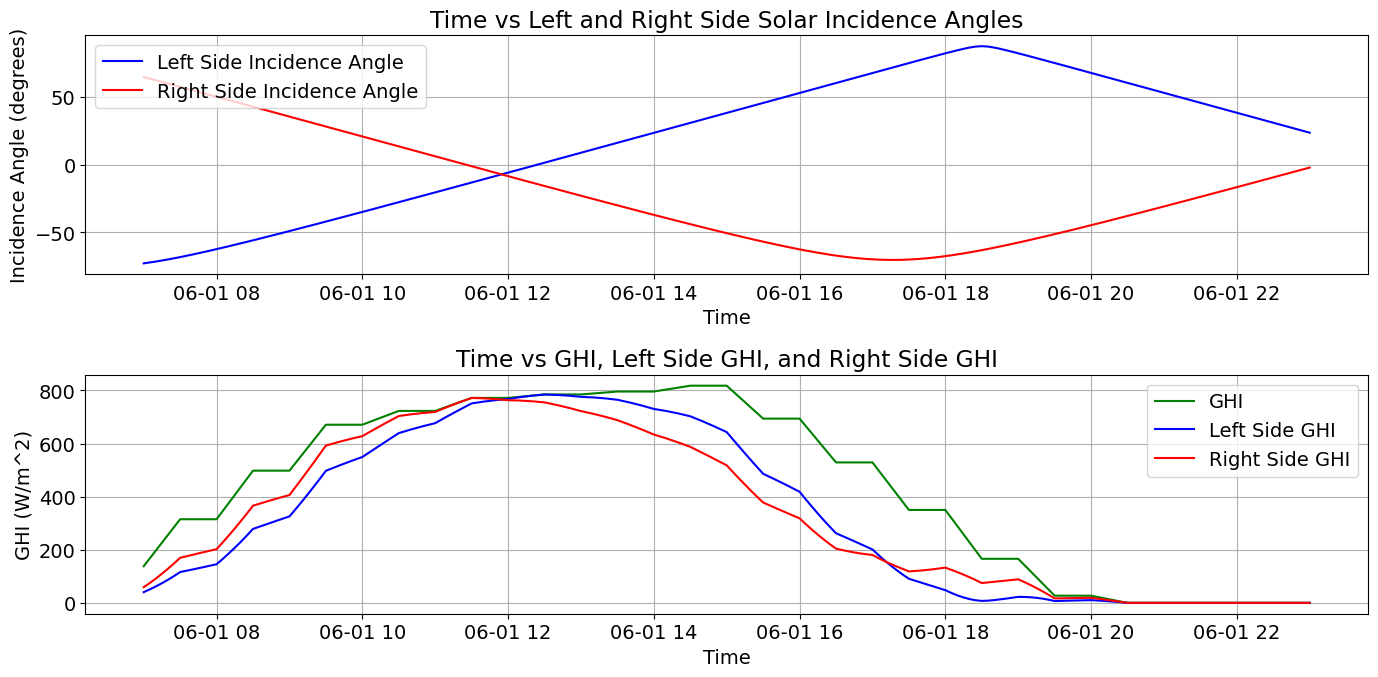

In [ ]:
def calculate_incidence_angle(delta, phi, beta, lambda_k, omega_k):
    """
    Calculate the angle of incidence for each side of the bus.

    Parameters:
    delta (float): Solar declination angle in radians.
    phi (float): Latitude of the location in radians.
    beta (float): Tilt angle of the bus sides in radians.
    lambda_k (float): Azimuth angle of the bus in radians.
    omega_k (float): Solar hour angle in radians.

    Returns:
    float: Angle of incidence in radians.
    """
    return np.arcsin(np.sin(delta) * np.sin(phi) * np.cos(beta) +
                     np.sin(delta) * np.cos(phi) * np.sin(beta) * np.cos(lambda_k) +
                     np.cos(delta) * np.cos(phi) * np.cos(omega_k) * np.cos(beta) -
                     np.cos(delta) * np.sin(phi) * np.cos(omega_k) * np.sin(beta) * np.cos(lambda_k) -
                     np.cos(delta) * np.sin(omega_k) * np.sin(beta) * np.sin(lambda_k))

def time_to_solar_hour_angle(time_str):
    """
    Convert time to solar hour angle.

    Parameters:
    time_str (str): Time in the format 'HH:MM:SS'.

    Returns:
    float: Solar hour angle in radians.
    """
    time_parts = time_str.split(':')
    hours = int(time_parts[0]) + int(time_parts[1]) / 60 + int(time_parts[2]) / 3600
    hour_angle_deg = (hours - 12) * 15
    return np.radians(hour_angle_deg)

def calculate_solar_incidence_angles(start_time, end_time, increment_minutes, delta, beta, phi=39.09, lambda_k=180):
    """
    Calculate solar incidence angles for the left and right sides of the bus for a specified time range with a given increment.

    Parameters:
    start_time (str): Start time in the format 'HH:MM:SS'.
    end_time (str): End time in the format 'HH:MM:SS'.
    increment_minutes (int): Time increment in minutes.
    delta (float): Solar declination angle in degrees.
    beta (float): Tilt angle of the bus sides in degrees.
    phi (float): Latitude of the location in degrees. Default is 39.09.
    lambda_k (float): Azimuth angle of the bus in degrees. Default is 180.

    Returns:
    pandas.DataFrame: DataFrame containing the time, solar incidence angles for the left side, and solar incidence angles for the right side in degrees.
    """
    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)
    time_range = pd.date_range(start=start_time, end=end_time, freq=f'{increment_minutes}T')
    results = []
    delta = np.radians(delta)
    phi = np.radians(phi)
    beta = np.radians(beta)

    # Introducing additional offset for non-symmetric angles
    left_static_offset = 10  # Example static offset for the left side
    right_static_offset = -15  # Example static offset for the right side

    for time in time_range:
        time_str = time.strftime('%H:%M:%S')
        omega_k = time_to_solar_hour_angle(time_str)

        # Dynamic offsets based on time (for example, adjusting by 0.1 degree per hour)
        hours = time.hour + time.minute / 60
        left_dynamic_offset = 0.1 * hours
        right_dynamic_offset = -0.1 * hours

        # Calculate the solar incidence angle for the left side of the bus
        lambda_k_left = np.radians(lambda_k + 90 + left_static_offset + left_dynamic_offset)
        theta_inc_left = calculate_incidence_angle(delta, phi, beta, lambda_k_left, omega_k)

        # Calculate the solar incidence angle for the right side of the bus
        lambda_k_right = np.radians(lambda_k - 90 + right_static_offset + right_dynamic_offset)
        theta_inc_right = calculate_incidence_angle(delta, phi, beta, lambda_k_right, omega_k)

        results.append({'Time': time_str, 'Left_Side': np.degrees(theta_inc_left), 'Right_Side': np.degrees(theta_inc_right)})

    return pd.DataFrame(results)

# Example usage:
start_time = '7:00:00'
end_time = '23:00:00'
increment_minutes = 5
delta = 6.6  # Solar declination angle in degrees for June 1st
beta = 90    # Tilt angle in degrees

solar_angles_df = calculate_solar_incidence_angles(start_time, end_time, increment_minutes, delta, beta)
solar_angles_df['Time'] = pd.to_datetime(solar_angles_df['Time'], format='%H:%M:%S').apply(lambda t: pd.Timestamp('2019-06-01 ' + t.strftime('%H:%M:%S')))
# Merge the two DataFrames on the 'Time' column
merged_df = pd.merge(df_pmv, solar_angles_df, on='Time', how='inner')
# Calculate Left Side GHI and Right Side GHI
merged_df['Left_Side_GHI'] = merged_df['GHI'] * np.cos(np.radians(merged_df['Left_Side']))
merged_df['Right_Side_GHI'] = merged_df['GHI'] * np.cos(np.radians(merged_df['Right_Side']))

# Drop unnecessary columns from merged_df if needed
# Keeping all original columns from df_updated and adding new columns
df_final = merged_df

# Display the updated DataFrame
print(df_final.head(100))

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot Time vs Left and Right Side Solar Incidence Angles
plt.subplot(2, 1, 1)
plt.plot(df_final['Time'], df_final['Left_Side'], label='Left Side Incidence Angle', color='blue')
plt.plot(df_final['Time'], df_final['Right_Side'], label='Right Side Incidence Angle', color='red')
plt.xlabel('Time')
plt.ylabel('Incidence Angle (degrees)')
plt.title('Time vs Left and Right Side Solar Incidence Angles')
plt.legend()
plt.grid(True)

# Plot Time vs GHI, Left Side GHI, and Right Side GHI
plt.subplot(2, 1, 2)
plt.plot(df_final['Time'], df_final['GHI'], label='GHI', color='green')
plt.plot(df_final['Time'], df_final['Left_Side_GHI'], label='Left Side GHI', color='blue')
plt.plot(df_final['Time'], df_final['Right_Side_GHI'], label='Right Side GHI', color='red')
plt.xlabel('Time')
plt.ylabel('GHI (W/m^2)')
plt.title('Time vs GHI, Left Side GHI, and Right Side GHI')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



**Calculation of PMVcorrected for left and right side of the bus**

In [ ]:
df_final['LeftPMV'] = df_final['PMV'] + 1/200 * df_final['Left_Side_GHI']
df_final['RightPMV'] = df_final['PMV'] + 1/200 * df_final['Right_Side_GHI']
df_final['AveragePMV'] = (df_final['LeftPMV'] + df_final['RightPMV']) / 2
df_final
#df_final.to_csv('df_final.csv', index=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Time,DateTime,Temperature,GHI,v,rh,ta,tr,met,clo,...,PMV,PPD,PMVcorrected,Left_Side,Right_Side,Left_Side_GHI,Right_Side_GHI,LeftPMV,RightPMV,AveragePMV
0,2019-06-01 07:00:00,2019-06-01 07:00:00,17.4,138.0,1.92,51.96,25,25,1.2,0.5,...,-1.30,40.2,-0.6100,-73.014165,64.688677,40.314668,59.000040,-1.098427,-1.005000,-1.051713
1,2019-06-01 07:05:00,2019-06-01 07:05:00,17.8,167.5,1.55,46.18,25,25,1.2,0.5,...,-1.23,36.6,-0.3925,-72.377404,63.478667,50.709919,74.793943,-0.976450,-0.856030,-0.916240
2,2019-06-01 07:10:00,2019-06-01 07:10:00,18.2,197.0,1.82,56.98,25,25,1.2,0.5,...,-1.23,36.9,-0.2450,-71.678619,62.266374,61.926305,91.676232,-0.920368,-0.771619,-0.845994
3,2019-06-01 07:15:00,2019-06-01 07:15:00,18.6,226.5,2.43,56.15,25,25,1.2,0.5,...,-1.39,45.1,-0.2575,-70.924628,61.052107,74.022847,109.629172,-1.019886,-0.841854,-0.930870
4,2019-06-01 07:20:00,2019-06-01 07:20:00,19.0,256.0,1.59,40.89,25,25,1.2,0.5,...,-1.28,39.1,0.0000,-70.121714,59.836123,87.045931,128.633587,-0.844770,-0.636832,-0.740801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,2019-06-01 22:40:00,2019-06-01 22:40:00,19.8,0.0,2.23,55.63,25,25,1.2,0.5,...,-1.35,42.9,-1.3500,28.424654,-7.080220,0.000000,0.000000,-1.350000,-1.350000,-1.350000
189,2019-06-01 22:45:00,2019-06-01 22:45:00,19.8,0.0,1.69,42.22,25,25,1.2,0.5,...,-1.30,40.3,-1.3000,27.198549,-5.870583,0.000000,0.000000,-1.300000,-1.300000,-1.300000
190,2019-06-01 22:50:00,2019-06-01 22:50:00,19.8,0.0,1.54,58.97,25,25,1.2,0.5,...,-1.13,32.0,-1.1300,25.972654,-4.660076,0.000000,0.000000,-1.130000,-1.130000,-1.130000
191,2019-06-01 22:55:00,2019-06-01 22:55:00,19.8,0.0,1.63,43.38,25,25,1.2,0.5,...,-1.27,38.9,-1.2700,24.746980,-3.448743,0.000000,0.000000,-1.270000,-1.270000,-1.270000


**PMVcorrected vs left side PMV and Right side PMV calculation**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Missing columns: ['newPMV']


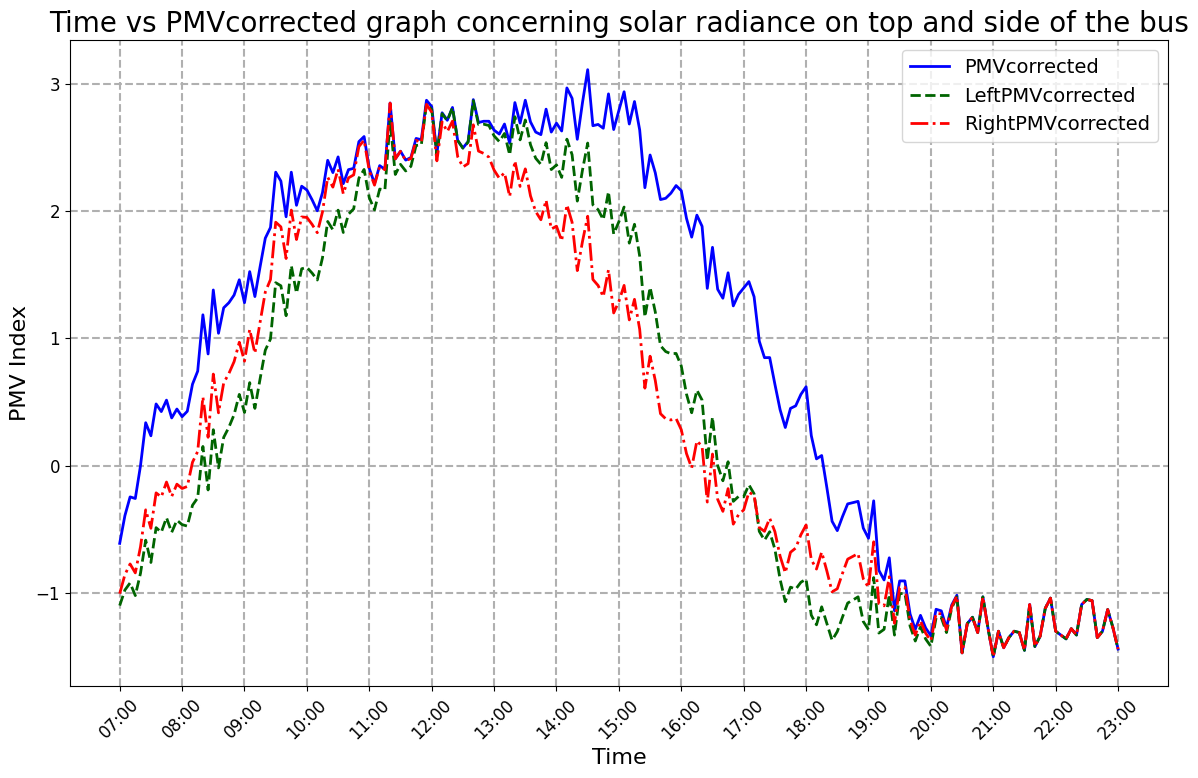

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Assuming 'df_final' is your DataFrame and already contains the necessary PMV columns
if 'Time' in df_final.columns:
    df_final['Time'] = pd.to_datetime(df_final['Time'])
    df_final.set_index('Time', inplace=True)

# Check for missing columns
required_columns = ['newPMV', 'LeftPMV', 'RightPMV', 'AveragePMV']
missing_columns = [col for col in required_columns if col not in df_final.columns]
if missing_columns:
    print(f"Missing columns: {missing_columns}")

# Plotting
plt.figure(figsize=(12, 8))

# Define line styles for better differentiation
line_styles = ['-', '--', '-.', ':']
colors = ['blue', 'darkgreen', 'red',]
labels = ['PMVcorrected', 'LeftPMVcorrected', 'RightPMVcorrected']

# Plot each PMV data series with different styles
plt.plot(df_final.index, df_final['PMVcorrected'], label=labels[0], linestyle=line_styles[0], color=colors[0], linewidth=2)
plt.plot(df_final.index, df_final['LeftPMV'], label=labels[1], linestyle=line_styles[1], color=colors[1], linewidth=2)
plt.plot(df_final.index, df_final['RightPMV'], label=labels[2], linestyle=line_styles[2], color=colors[2], linewidth=2)

# Formatting the plot
plt.xlabel('Time', fontsize=16)
plt.ylabel('PMV Index', fontsize=16)
plt.title('Time vs PMVcorrected graph concerning solar radiance on top and side of the bus', fontsize=20)
plt.legend(fontsize=14, loc='best')
plt.grid(True, linestyle='--', linewidth=1.5)

# Date formatting on the x-axis
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

35.748000000000005


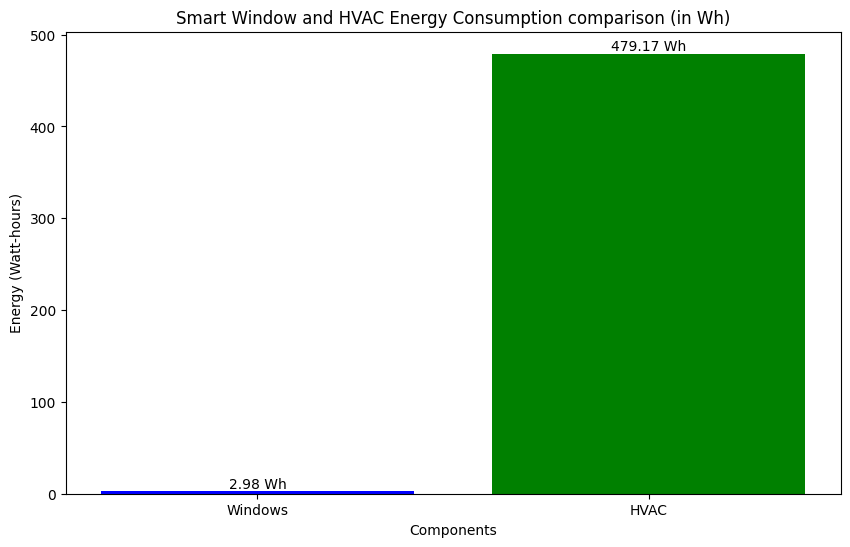

In [ ]:
import matplotlib.pyplot as plt

def P_film(V_film, f_film, eta):
    #numerator = ((2.474 * A + 80.55) * 10**-9) * (2 * V_film)**2 * f_film
    numerator = ((1655) * 10**-9) * (2 * V_film)**2 * f_film  #using the same cell capacitance value of 531 sq.in resides in the lab.
    denominator = (1 - eta)
    return numerator / denominator

# Calculate power consumption in watts for continuous operation
power_windows = 12* P_film(15, 200, 0.9)  # Total for 12 windows
print(power_windows)

# Calculate energy consumption in watt-hours for 5 minutes
energy_windows_5min_Wh = power_windows * (5 / 60)   # Convert power to energy for 5 minutes
#print(energy_windows_5min_Wh)

# HVAC power consumption in watts (assuming 5.75 kWh is per hour)
kWh_hvac = 5.75
power_hvac_W = kWh_hvac * 1000  # Convert kWh to watts for one hour
energy_hvac_5min_Wh = power_hvac_W * (5 / 60)  # Convert power to energy for 5 minutes

# Data preparation for a 5-minute period comparison
components = ['Windows', 'HVAC']
energy_values_wh = [energy_windows_5min_Wh, energy_hvac_5min_Wh]  # Use energy in watt-hours

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(components, energy_values_wh, color=['blue', 'green'])

# Annotate bars with the exact values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f} Wh', ha='center', va='bottom', fontsize=10, color='black')

plt.title('Smart Window and HVAC Energy Consumption comparison (in Wh)')
plt.ylabel('Energy (Watt-hours)')
plt.xlabel('Components')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


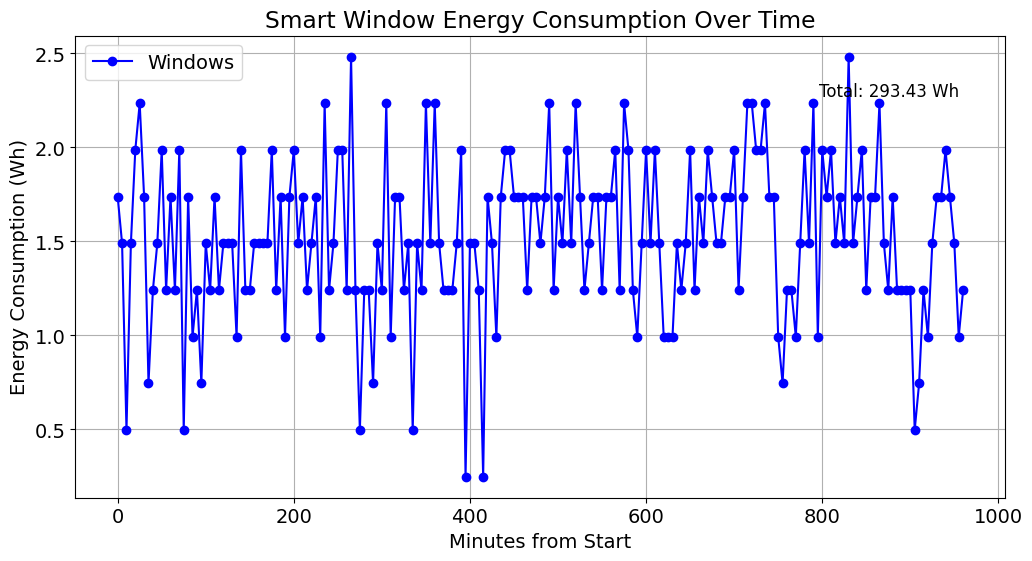

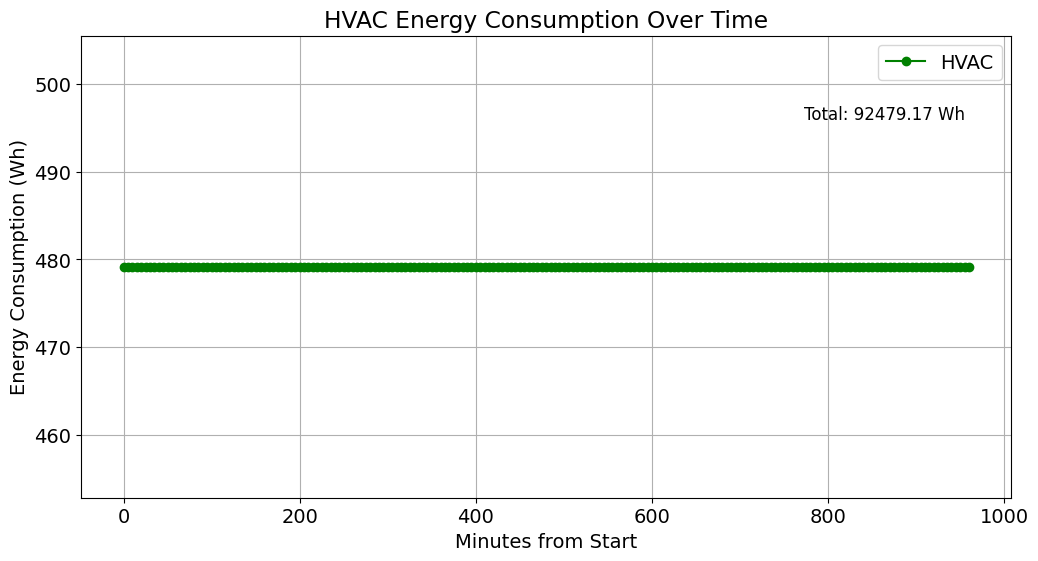

In [ ]:
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta
import numpy as np  # Needed for numerical operations like standard deviation

def P_film(V_film, f_film, eta):
    #numerator = ((2.474 * A + 80.55) * 10**-9) * (2 * V_film)**2 * f_film
    numerator = ((1655) * 10**-9) * (2 * V_film)**2 * f_film  #using the same cell capacitance value of 531 sq.in resides in the lab.
    denominator = (1 - eta)
    return numerator / denominator


class Bus:
    def __init__(self, length, width, height, num_windows_per_side, num_rows):
        self.length = length
        self.width = width
        self.height = height
        self.num_windows_per_side = num_windows_per_side
        self.num_rows = num_rows
        self.window_status = [[[False] * num_windows_per_side for _ in range(num_rows)],
                              [[False] * num_windows_per_side for _ in range(num_rows)]]
        self.power_per_window = P_film(15, 200, 0.9)  # Power per window
        self.kWh_hvac = 5.75
        self.energy_windows = []
        self.energy_hvac = []

    def randomize_windows(self):
        for side in range(2):
            for row in range(self.num_rows):
                for window in range(self.num_windows_per_side):
                    self.window_status[side][row][window] = random.choice([True, False])

    def simulate_time_period(self, start_time, end_time, increment_minutes):
        start_dt = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
        end_dt = datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S')
        current_dt = start_dt

        while current_dt <= end_dt:
            self.randomize_windows()
            open_windows = sum(sum(row.count(True) for row in side) for side in self.window_status)
            energy_windows_this_period = open_windows * self.power_per_window * (increment_minutes / 60)
            self.energy_windows.append(energy_windows_this_period)

            power_hvac = self.kWh_hvac * 1000  # Power in watts
            energy_hvac_this_period = power_hvac * (increment_minutes / 60)  # Energy per increment
            self.energy_hvac.append(energy_hvac_this_period)

            current_dt += timedelta(minutes=increment_minutes)

    def visualize_energy_usage(self):
        time_labels = [i * 5 for i in range(len(self.energy_windows))]

        # Window Energy Consumption
        plt.figure(figsize=(12, 6))
        plt.plot(time_labels, self.energy_windows, label='Windows', marker='o', color='blue')
        total_windows_energy = sum(self.energy_windows)

        # Text positioned at the top of the figure just below the title
        plt.text(0.95, 0.90, f'Total: {total_windows_energy:.2f} Wh', fontsize=12,
                 verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes)

        plt.xlabel('Minutes from Start')
        plt.ylabel('Energy Consumption (Wh)')
        plt.title('Smart Window Energy Consumption Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()

        # HVAC Energy Consumption
        plt.figure(figsize=(12, 6))
        plt.plot(time_labels, self.energy_hvac, label='HVAC', marker='o', color='green')
        total_hvac_energy = sum(self.energy_hvac)

        # Text positioned at the top of the figure just below the title
        plt.text(0.95, 0.85, f'Total: {total_hvac_energy:.2f} Wh', fontsize=12,
                 verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes)

        plt.xlabel('Minutes from Start')
        plt.ylabel('Energy Consumption (Wh)')
        plt.title('HVAC Energy Consumption Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage
bus = Bus(length=11, width=2.6, height=3.3, num_windows_per_side=6, num_rows=1)
bus.simulate_time_period('2019-06-01 07:00:00', '2019-06-01 23:00:00', 5)
bus.visualize_energy_usage()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


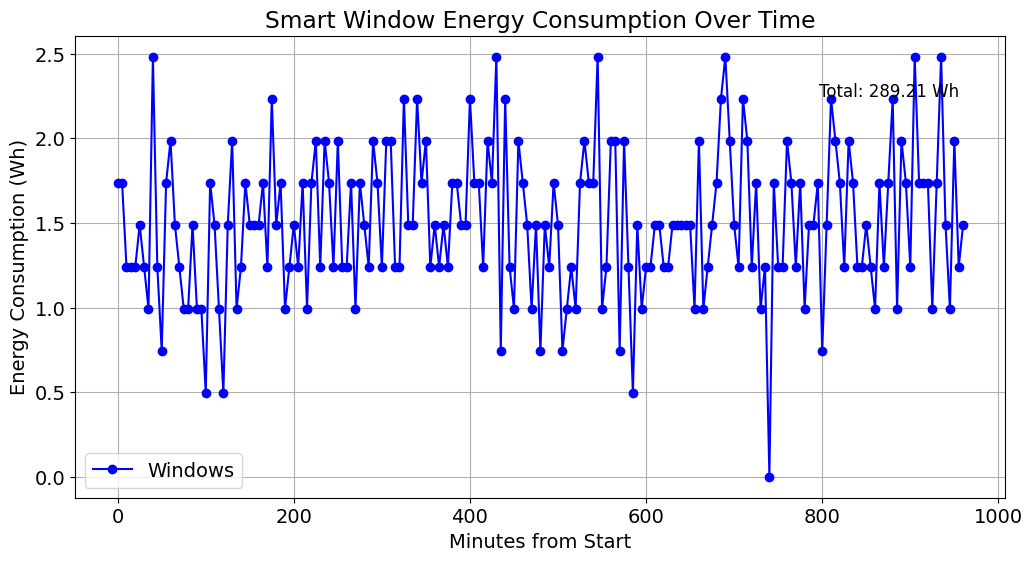

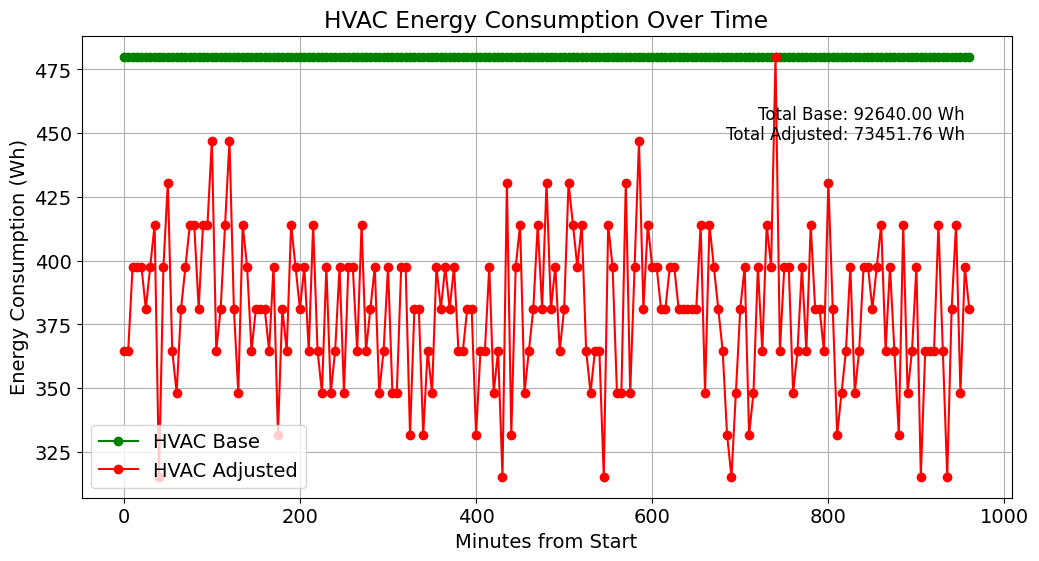

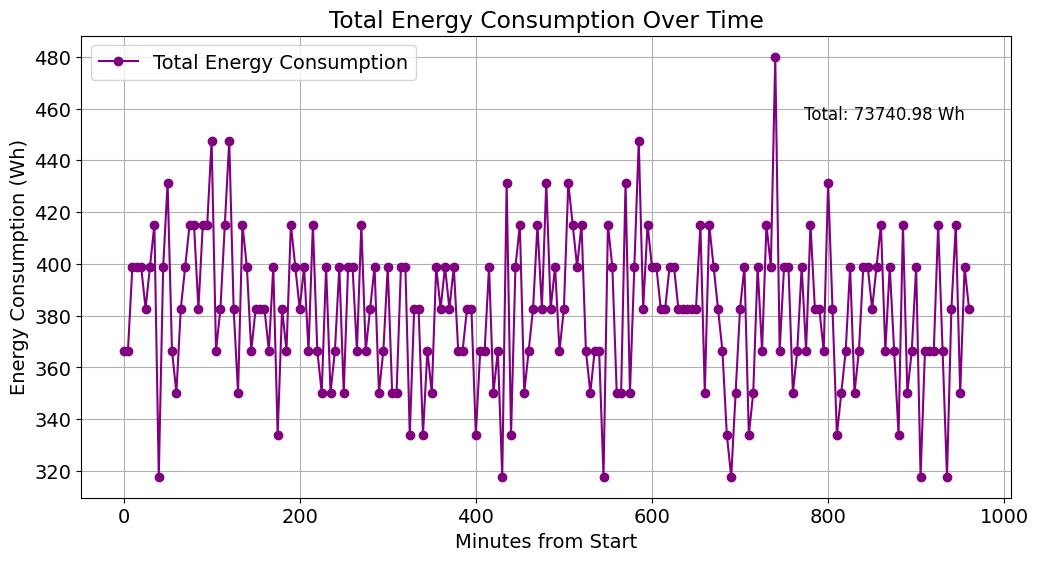

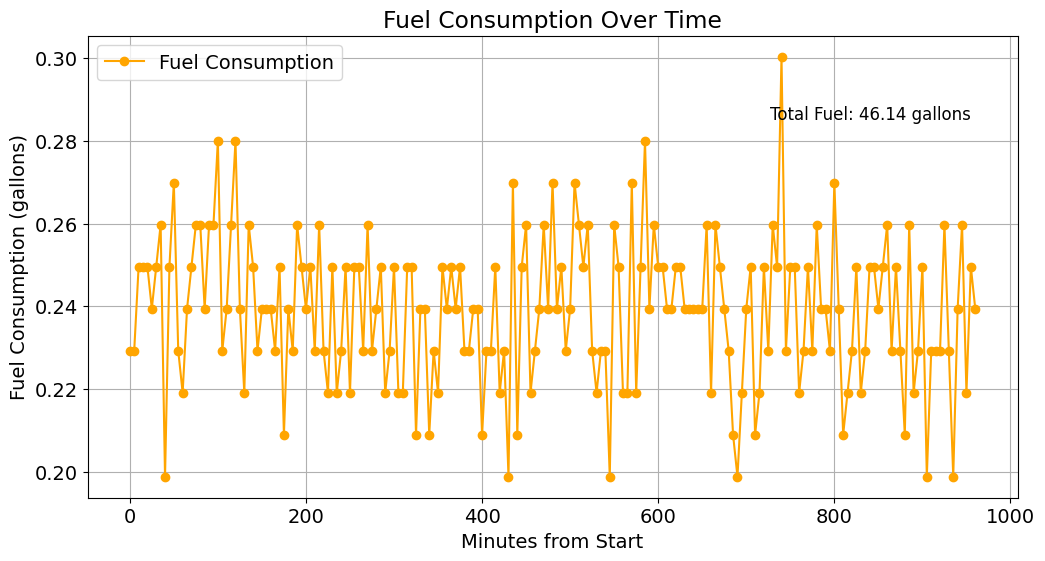

In [ ]:
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta
import numpy as np  # Needed for numerical operations like standard deviation

def P_film(V_film, f_film, eta):
    numerator = ((1655) * 10**-9) * (2 * V_film)**2 * f_film  # Using the same cell capacitance value of 531 sq.in resides in the lab.
    denominator = (1 - eta)
    return numerator / denominator

class Bus:
    def __init__(self, length, width, height, num_windows_per_side, num_rows):
        self.length = length
        self.width = width
        self.height = height
        self.num_windows_per_side = num_windows_per_side
        self.num_rows = num_rows
        self.window_status = [[[False] * num_windows_per_side for _ in range(num_rows)],
                              [[False] * num_windows_per_side for _ in range(num_rows)]]
        self.power_per_window = P_film(15, 200, 0.9)  # Power per window
        self.kWh_hvac = 5.75
        self.energy_windows = []
        self.energy_hvac = []
        self.energy_hvac_saved = []
        self.total_energy_consumption = []
        self.fuel_consumption_gallons = []

    def randomize_windows(self):
        for side in range(2):
            for row in range(self.num_rows):
                for window in range(self.num_windows_per_side):
                    self.window_status[side][row][window] = random.choice([True, False])

    def calculate_mu(self):
        SHGC_off = 0.68
        SHGC_on = 0.40
        N_total = self.num_windows_per_side * self.num_rows * 2  # Total number of windows
        open_windows = sum(sum(row.count(True) for row in side) for side in self.window_status)
        closed_windows = N_total - open_windows

        mu = (N_total * SHGC_off - open_windows * SHGC_on - closed_windows * SHGC_off) / (N_total * SHGC_off)
        return mu

    def simulate_time_period(self, start_time, end_time, increment_minutes):
        start_dt = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
        end_dt = datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S')
        current_dt = start_dt

        while current_dt <= end_dt:
            self.randomize_windows()
            open_windows = sum(sum(row.count(True) for row in side) for side in self.window_status)
            energy_windows_this_period = open_windows * self.power_per_window * (increment_minutes / 60)
            self.energy_windows.append(energy_windows_this_period)

            power_hvac_base = 480  # Base HVAC power in Wh per 5 minutes
            mu = self.calculate_mu()
            energy_hvac_this_period = power_hvac_base * (1 - mu)  # Adjusted energy consumption
            self.energy_hvac.append(power_hvac_base)
            self.energy_hvac_saved.append(energy_hvac_this_period)

            total_energy = energy_windows_this_period + energy_hvac_this_period
            self.total_energy_consumption.append(total_energy)

            fuel_consumption_gallons = self.calculate_fuel_consumption(total_energy, increment_minutes)
            self.fuel_consumption_gallons.append(fuel_consumption_gallons)

            current_dt += timedelta(minutes=increment_minutes)

    def calculate_fuel_consumption(self, total_energy, increment_minutes):
        c_fs = 165  # Fuel consumption rate in g/kWh
        rho = 836  # Density of diesel fuel in g/L
        liters_to_gallons = 0.264172  # Conversion factor from liters to gallons

        total_energy_kWh = total_energy / 1000  # Convert Wh to kWh
        t_total = increment_minutes / 60  # Total operating time for each time step in hours
        fuel_consumption_liters = (total_energy_kWh / t_total) * c_fs / rho  # Fuel consumption in liters
        fuel_consumption_gallons = fuel_consumption_liters * liters_to_gallons  # Convert to gallons

        return fuel_consumption_gallons

    def visualize_energy_usage(self):
        time_labels = [i * 5 for i in range(len(self.energy_windows))]

        # Window Energy Consumption
        plt.figure(figsize=(12, 6))
        plt.plot(time_labels, self.energy_windows, label='Windows', marker='o', color='blue')
        total_windows_energy = sum(self.energy_windows)

        # Text positioned at the top of the figure just below the title
        plt.text(0.95, 0.90, f'Total: {total_windows_energy:.2f} Wh', fontsize=12,
                 verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes)

        plt.xlabel('Minutes from Start')
        plt.ylabel('Energy Consumption (Wh)')
        plt.title('Smart Window Energy Consumption Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()

        # HVAC Energy Consumption
        plt.figure(figsize=(12, 6))
        plt.plot(time_labels, self.energy_hvac, label='HVAC Base', marker='o', color='green')
        plt.plot(time_labels, self.energy_hvac_saved, label='HVAC Adjusted', marker='o', color='red')
        total_hvac_energy_base = sum(self.energy_hvac)
        total_hvac_energy_saved = sum(self.energy_hvac_saved)

        # Text positioned at the top of the figure just below the title
        plt.text(0.95, 0.85, f'Total Base: {total_hvac_energy_base:.2f} Wh\nTotal Adjusted: {total_hvac_energy_saved:.2f} Wh', fontsize=12,
                 verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes)

        plt.xlabel('Minutes from Start')
        plt.ylabel('Energy Consumption (Wh)')
        plt.title('HVAC Energy Consumption Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Total Energy Consumption
        plt.figure(figsize=(12, 6))
        plt.plot(time_labels, self.total_energy_consumption, label='Total Energy Consumption', marker='o', color='purple')
        total_energy_consumption = sum(self.total_energy_consumption)

        # Text positioned at the top of the figure just below the title
        plt.text(0.95, 0.85, f'Total: {total_energy_consumption:.2f} Wh', fontsize=12,
                 verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes)

        plt.xlabel('Minutes from Start')
        plt.ylabel('Energy Consumption (Wh)')
        plt.title('Total Energy Consumption Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Fuel Consumption per Time Step
        plt.figure(figsize=(12, 6))
        plt.plot(time_labels, self.fuel_consumption_gallons, label='Fuel Consumption', marker='o', color='orange')
        total_fuel_consumption = sum(self.fuel_consumption_gallons)

        # Text positioned at the top of the figure just below the title
        plt.text(0.95, 0.85, f'Total Fuel: {total_fuel_consumption:.2f} gallons', fontsize=12,
                 verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes)

        plt.xlabel('Minutes from Start')
        plt.ylabel('Fuel Consumption (gallons)')
        plt.title('Fuel Consumption Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage
bus = Bus(length=11, width=2.6, height=3.3, num_windows_per_side=6, num_rows=1)
bus.simulate_time_period('2019-06-01 07:00:00', '2019-06-01 23:00:00', 5)
bus.visualize_energy_usage()

In [ ]:
df_final

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,DateTime,Temperature,GHI,v,rh,ta,tr,met,clo,vr,...,PMV,PPD,PMVcorrected,Left_Side,Right_Side,Left_Side_GHI,Right_Side_GHI,LeftPMV,RightPMV,AveragePMV
Time,,,,,,,,,,,,,,,,,,,,,
2019-06-01 07:00:00,2019-06-01 07:00:00,17.4,138.0,2.24,56.91,25,25,1.2,0.5,2.30,...,-1.34,42.5,-0.6500,-73.014165,64.688677,40.314668,59.000040,-1.138427,-1.045000,-1.091713
2019-06-01 07:05:00,2019-06-01 07:05:00,17.8,167.5,2.29,55.62,25,25,1.2,0.5,2.35,...,-1.36,43.6,-0.5225,-72.377404,63.478667,50.709919,74.793943,-1.106450,-0.986030,-1.046240
2019-06-01 07:10:00,2019-06-01 07:10:00,18.2,197.0,2.02,42.75,25,25,1.2,0.5,2.08,...,-1.39,45.0,-0.4050,-71.678619,62.266374,61.926305,91.676232,-1.080368,-0.931619,-1.005994
2019-06-01 07:15:00,2019-06-01 07:15:00,18.6,226.5,2.43,53.01,25,25,1.2,0.5,2.49,...,-1.41,46.3,-0.2775,-70.924628,61.052107,74.022847,109.629172,-1.039886,-0.861854,-0.950870
2019-06-01 07:20:00,2019-06-01 07:20:00,19.0,256.0,1.92,43.83,25,25,1.2,0.5,1.98,...,-1.36,43.1,-0.0800,-70.121714,59.836123,87.045931,128.633587,-0.924770,-0.716832,-0.820801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-01 22:40:00,2019-06-01 22:40:00,19.8,0.0,1.36,43.56,25,25,1.2,0.5,1.42,...,-1.18,34.1,-1.1800,28.424654,-7.080220,0.000000,0.000000,-1.180000,-1.180000,-1.180000
2019-06-01 22:45:00,2019-06-01 22:45:00,19.8,0.0,2.44,46.59,25,25,1.2,0.5,2.50,...,-1.46,48.8,-1.4600,27.198549,-5.870583,0.000000,0.000000,-1.460000,-1.460000,-1.460000
2019-06-01 22:50:00,2019-06-01 22:50:00,19.8,0.0,2.43,55.26,25,25,1.2,0.5,2.49,...,-1.40,45.4,-1.4000,25.972654,-4.660076,0.000000,0.000000,-1.400000,-1.400000,-1.400000


In [ ]:
df_final.to_csv('df_final.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo